# Project 3: Webscraping, NLP and classification modelling

# Contents:

1) Sentiment Analysis with Vader Library  
2) Classification model to predict positive posts  
2) Topic Modelling with LDA  
3) Exploring if sentiment is linked to upvotes   

In [1]:
# library imports
import requests
import time
import pandas as pd
import numpy as np
import ast
import re
from tqdm import tqdm

# preprocessing imports
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# modeling imports
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import SVR
sid = SentimentIntensityAnalyzer()

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
reddit_df = pd.read_csv('../datasets/cleaned_for_modelling_30_nov_df.csv')

# Sentiment Analysis

In [3]:
reddit_df['scores'] = reddit_df['cleaned_text'].apply(lambda review: sid.polarity_scores(review))

reddit_df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text,scores
0,Just need to vent...,"I get that tempers are shorter these days, but...",230,0,0,Just need to vent... I get that tempers are sh...,"['need', 'vent', 'get', 'tempers', 'shorter', ...",Just need to vent... I get that tempers are sh...,1,48,579,need vent get tempers shorter days hard time l...,"{'neg': 0.194, 'neu': 0.467, 'pos': 0.339, 'co..."
1,Reverse call center post,On mobile so I hope I do this right. \n\nI ha...,39,0,0,Reverse call center post On mobile so I hope I...,"['reverse', 'call', 'center', 'post', 'mobile'...",Reverse call center post On mobile so I hope I...,0,84,1017,reverse call center post mobile hope right cal...,"{'neg': 0.112, 'neu': 0.645, 'pos': 0.243, 'co..."
2,"""So you're willing to lose a customer for $3 d...",I work for a car rental company as a specialis...,763,0,0,"""So you're willing to lose a customer for $3 d...","['willing', 'lose', 'customer', 'dollars', 'wo...","""So you're willing to lose a customer for $3 d...",1,585,6757,willing lose customer dollars work car rental ...,"{'neg': 0.136, 'neu': 0.657, 'pos': 0.207, 'co..."
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk...,"['free', 'talk', 'friday', 'nov', 'welcome', '...",Free Talk Friday - Nov 27 Welcome to Free Talk...,0,38,368,free talk friday nov welcome free talk friday ...,"{'neg': 0.169, 'neu': 0.562, 'pos': 0.269, 'co..."
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the thin...,958,0,0,Accidentally Exposed a Family Fraud I work for...,"['accidentally', 'exposed', 'family', 'fraud',...",Accidentally Exposed a Family Fraud I work for...,1,366,3608,accidentally exposed family fraud work small l...,"{'neg': 0.171, 'neu': 0.74, 'pos': 0.089, 'com..."


In [4]:
reddit_df['compound']  = reddit_df['scores'].apply(lambda score_dict: score_dict['compound'])

reddit_df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text,scores,compound
0,Just need to vent...,"I get that tempers are shorter these days, but...",230,0,0,Just need to vent... I get that tempers are sh...,"['need', 'vent', 'get', 'tempers', 'shorter', ...",Just need to vent... I get that tempers are sh...,1,48,579,need vent get tempers shorter days hard time l...,"{'neg': 0.194, 'neu': 0.467, 'pos': 0.339, 'co...",0.8834
1,Reverse call center post,On mobile so I hope I do this right. \n\nI ha...,39,0,0,Reverse call center post On mobile so I hope I...,"['reverse', 'call', 'center', 'post', 'mobile'...",Reverse call center post On mobile so I hope I...,0,84,1017,reverse call center post mobile hope right cal...,"{'neg': 0.112, 'neu': 0.645, 'pos': 0.243, 'co...",0.9183
2,"""So you're willing to lose a customer for $3 d...",I work for a car rental company as a specialis...,763,0,0,"""So you're willing to lose a customer for $3 d...","['willing', 'lose', 'customer', 'dollars', 'wo...","""So you're willing to lose a customer for $3 d...",1,585,6757,willing lose customer dollars work car rental ...,"{'neg': 0.136, 'neu': 0.657, 'pos': 0.207, 'co...",0.9939
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk...,"['free', 'talk', 'friday', 'nov', 'welcome', '...",Free Talk Friday - Nov 27 Welcome to Free Talk...,0,38,368,free talk friday nov welcome free talk friday ...,"{'neg': 0.169, 'neu': 0.562, 'pos': 0.269, 'co...",0.6124
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the thin...,958,0,0,Accidentally Exposed a Family Fraud I work for...,"['accidentally', 'exposed', 'family', 'fraud',...",Accidentally Exposed a Family Fraud I work for...,1,366,3608,accidentally exposed family fraud work small l...,"{'neg': 0.171, 'neu': 0.74, 'pos': 0.089, 'com...",-0.9880


In [5]:
reddit_df['comp_score'] = reddit_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

reddit_df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text,scores,compound,comp_score
0,Just need to vent...,"I get that tempers are shorter these days, but...",230,0,0,Just need to vent... I get that tempers are sh...,"['need', 'vent', 'get', 'tempers', 'shorter', ...",Just need to vent... I get that tempers are sh...,1,48,579,need vent get tempers shorter days hard time l...,"{'neg': 0.194, 'neu': 0.467, 'pos': 0.339, 'co...",0.8834,pos
1,Reverse call center post,On mobile so I hope I do this right. \n\nI ha...,39,0,0,Reverse call center post On mobile so I hope I...,"['reverse', 'call', 'center', 'post', 'mobile'...",Reverse call center post On mobile so I hope I...,0,84,1017,reverse call center post mobile hope right cal...,"{'neg': 0.112, 'neu': 0.645, 'pos': 0.243, 'co...",0.9183,pos
2,"""So you're willing to lose a customer for $3 d...",I work for a car rental company as a specialis...,763,0,0,"""So you're willing to lose a customer for $3 d...","['willing', 'lose', 'customer', 'dollars', 'wo...","""So you're willing to lose a customer for $3 d...",1,585,6757,willing lose customer dollars work car rental ...,"{'neg': 0.136, 'neu': 0.657, 'pos': 0.207, 'co...",0.9939,pos
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk...,"['free', 'talk', 'friday', 'nov', 'welcome', '...",Free Talk Friday - Nov 27 Welcome to Free Talk...,0,38,368,free talk friday nov welcome free talk friday ...,"{'neg': 0.169, 'neu': 0.562, 'pos': 0.269, 'co...",0.6124,pos
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the thin...,958,0,0,Accidentally Exposed a Family Fraud I work for...,"['accidentally', 'exposed', 'family', 'fraud',...",Accidentally Exposed a Family Fraud I work for...,1,366,3608,accidentally exposed family fraud work small l...,"{'neg': 0.171, 'neu': 0.74, 'pos': 0.089, 'com...",-0.9880,neg


In [6]:
reddit_df['is_positive'] = reddit_df['comp_score'].apply(lambda c: 1 if c =='pos' else 0)

reddit_df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text,scores,compound,comp_score,is_positive
0,Just need to vent...,"I get that tempers are shorter these days, but...",230,0,0,Just need to vent... I get that tempers are sh...,"['need', 'vent', 'get', 'tempers', 'shorter', ...",Just need to vent... I get that tempers are sh...,1,48,579,need vent get tempers shorter days hard time l...,"{'neg': 0.194, 'neu': 0.467, 'pos': 0.339, 'co...",0.8834,pos,1
1,Reverse call center post,On mobile so I hope I do this right. \n\nI ha...,39,0,0,Reverse call center post On mobile so I hope I...,"['reverse', 'call', 'center', 'post', 'mobile'...",Reverse call center post On mobile so I hope I...,0,84,1017,reverse call center post mobile hope right cal...,"{'neg': 0.112, 'neu': 0.645, 'pos': 0.243, 'co...",0.9183,pos,1
2,"""So you're willing to lose a customer for $3 d...",I work for a car rental company as a specialis...,763,0,0,"""So you're willing to lose a customer for $3 d...","['willing', 'lose', 'customer', 'dollars', 'wo...","""So you're willing to lose a customer for $3 d...",1,585,6757,willing lose customer dollars work car rental ...,"{'neg': 0.136, 'neu': 0.657, 'pos': 0.207, 'co...",0.9939,pos,1
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk...,"['free', 'talk', 'friday', 'nov', 'welcome', '...",Free Talk Friday - Nov 27 Welcome to Free Talk...,0,38,368,free talk friday nov welcome free talk friday ...,"{'neg': 0.169, 'neu': 0.562, 'pos': 0.269, 'co...",0.6124,pos,1
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the thin...,958,0,0,Accidentally Exposed a Family Fraud I work for...,"['accidentally', 'exposed', 'family', 'fraud',...",Accidentally Exposed a Family Fraud I work for...,1,366,3608,accidentally exposed family fraud work small l...,"{'neg': 0.171, 'neu': 0.74, 'pos': 0.089, 'com...",-0.9880,neg,0


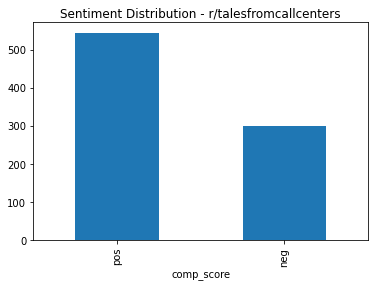

In [16]:
reddit_df.groupby('belongs_to_sub2')['comp_score'].value_counts()[0].plot(kind = 'bar')
plt.title('Sentiment Distribution - r/talesfromcallcenters');

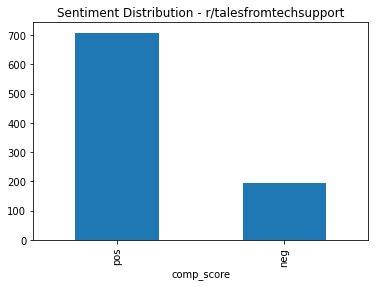

In [17]:
reddit_df.groupby('belongs_to_sub2')['comp_score'].value_counts()[1].plot(kind = 'bar')
plt.title('Sentiment Distribution - r/talesfromtechsupport');

In [131]:
X = reddit_df['cleaned_text']
y = reddit_df['is_positive']

In [10]:
#baseline accurary
y.value_counts(normalize= True)

1    0.722892
0    0.277108
Name: is_positive, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, #to keep the same balance of y in the test and train data
                                                    random_state = 42)



In [12]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])




In [13]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 5000, 10,000, 15,000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],
    'cvec__min_df' : [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

In [14]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [15]:
# Fit GridSearch to training data.
gs.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [16]:
# What's the best score?
gs.best_score_

0.7482524640987395

In [17]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [18]:
# Save best model as gs_model.

gs_model = gs.best_estimator_

In [19]:
# Score model on training set.
gs_model.score(X_train, y_train)

1.0

In [20]:
# Score model on testing set.
gs_model.score(X_test, y_test)

0.7408256880733946

In [58]:
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('nb', MultinomialNB())
])

In [59]:
params2 = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__ngram_range' : [(1,1), (1,2)]
}

In [60]:
gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5)

In [61]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [5000, 10000, 15000],
                         'tf__ngram_range': [(1, 1), (1, 2)]})

In [62]:
gs_train_accuracy = round(gs2.score(X_train, y_train),2)
print(f'Train Accuracy: {gs_train_accuracy}')

Train Accuracy: 0.73


In [63]:
gs_test_accuracy = round(gs2.score(X_test, y_test),2)
print(f'Test Accuracy: {gs_test_accuracy}')

Test Accuracy: 0.72


# Modelling to see if there is any relationship b/w sentiment score and upvotes

In [58]:
X_up = reddit_df[['compound']]
y_up = reddit_df['upvotes']

In [59]:
#baseline model accuray 
y_up.mean()

526.1681009753299

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_up, 
                                                    y_up, 
                                                    random_state = 42)

In [61]:
#initialize scaler
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)



In [62]:
# Instantiate support vector machine.
svr = SVR()

In [63]:
# Fit support vector machine to training data.
svr.fit(X_train, y_train)

SVR()

In [64]:
svr.score(X_train, y_train)

-0.17126975627466368

In [65]:
svr.score(X_test, y_test)

-0.1636214025212428

# Topic visualization

In [102]:
reddit_df.head()

,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text,scores
0,Just need to vent...,"I get that tempers are shorter these days, but I am having a hard time lately with people taking...",230,0,0,"Just need to vent... I get that tempers are shorter these days, but I am having a hard time late...","['need', 'vent', 'get', 'tempers', 'shorter', 'days', 'hard', 'time', 'lately', 'people', 'takin...","Just need to vent... I get that tempers are shorter these days, but I am having a hard time late...",1,48,579,need vent get tempers shorter days hard time lately people taking frustrations happen convenient...,"{'neg': 0.194, 'neu': 0.467, 'pos': 0.339, 'compound': 0.8834}"
1,Reverse call center post,On mobile so I hope I do this right. \n\nI had to call about a bill we keep getting for trash s...,39,0,0,Reverse call center post On mobile so I hope I do this right. \n\nI had to call about a bill we...,"['reverse', 'call', 'center', 'post', 'mobile', 'hope', 'right', 'call', 'bill', 'keep', 'gettin...",Reverse call center post On mobile so I hope I do this right. \n\nI had to call about a bill we...,0,84,1017,reverse call center post mobile hope right call bill keep getting trash service cancelled septem...,"{'neg': 0.112, 'neu': 0.645, 'pos': 0.243, 'compound': 0.9183}"
2,"""So you're willing to lose a customer for $3 dollars?""",I work for a car rental company as a specialist. Basically when a customer demands a supervisor ...,763,0,0,"""So you're willing to lose a customer for $3 dollars?"" I work for a car rental company as a spec...","['willing', 'lose', 'customer', 'dollars', 'work', 'car', 'rental', 'company', 'specialist', 'ba...","""So you're willing to lose a customer for $3 dollars?"" I work for a car rental company as a spec...",1,585,6757,willing lose customer dollars work car rental company specialist basically customer demands supe...,"{'neg': 0.136, 'neu': 0.657, 'pos': 0.207, 'compound': 0.9939}"
3,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending the usual 'tales only' rule within this thread (o...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk Friday! We are suspending the usual 'tales only' ...,"['free', 'talk', 'friday', 'nov', 'welcome', 'free', 'talk', 'friday', 'suspending', 'usual', 't...",Free Talk Friday - Nov 27 Welcome to Free Talk Friday! We are suspending the usual 'tales only' ...,0,38,368,free talk friday nov welcome free talk friday suspending usual tales rule within thread rules st...,"{'neg': 0.169, 'neu': 0.562, 'pos': 0.269, 'compound': 0.6124}"
4,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the things I sometime do is help out the billing person &a...,958,0,0,Accidentally Exposed a Family Fraud I work for a small local ISP. One of the things I sometime ...,"['accidentally', 'exposed', 'family', 'fraud', 'work', 'small', 'local', 'isp', 'one', 'things',...",Accidentally Exposed a Family Fraud I work for a small local ISP. One of the things I sometime ...,1,366,3608,accidentally exposed family fraud work small local isp one things sometime help billing person a...,"{'neg': 0.171, 'neu': 0.74, 'pos': 0.089, 'compound': -0.988}"


In [103]:
# Convert to list
data = reddit_df['token']
data_words = list(reddit_df['token'])
print(data_words[:1])

["['need', 'vent', 'get', 'tempers', 'shorter', 'days', 'hard', 'time', 'lately', 'people', 'taking', 'frustrations', 'happen', 'convenient', 'work', 'inbound', 'support', 'call', 'centre', 'try', 'hard', 'release', 'call', 'possible', 'spoke', 'real', 'special', 'person', 'today', 'going', 'file', 'complaint', 'pointed', 'violated', 'terms', 'use', 'close', 'done', 'job', 'mean', 'thanks', 'awards', 'thanks', 'everyone', 'support', 'definitely', 'feeling', 'better']"]


In [108]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [109]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.072*"com" + 0.071*"comment" + 0.067*"reddit" + 0.060*"www" + 0.046*"http" + 0.024*"damage" + 0.020*"amp" + 0.020*"scan" + 0.015*"tale" + 0.012*"tft"'), (1, '0.022*"customer" + 0.016*"email" + 0.013*"call" + 0.011*"need" + 0.011*"system" + 0.010*"number" + 0.010*"company" + 0.010*"want" + 0.010*"send" + 0.010*"office"'), (2, '0.043*"card" + 0.014*"owner" + 0.012*"ship" + 0.012*"profile" + 0.010*"terminal" + 0.009*"refund" + 0.009*"firm" + 0.008*"transaction" + 0.008*"credit" + 0.007*"purchase"'), (3, '0.020*"work" + 0.014*"call" + 0.014*"get" + 0.013*"user" + 0.012*"go" + 0.010*"time" + 0.008*"support" + 0.008*"know" + 0.007*"back" + 0.007*"try"')]


In [82]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7846,"work, call, get, user, go, time, support, know...","[need, vent, get, temper, short, day, hard, ti..."
1,1,1.0,0.6453,"customer, email, call, need, system, number, c...","[reverse, call, hope, right, call, bill, keep,..."
2,2,1.0,0.7012,"customer, email, call, need, system, number, c...","[willing, lose, customer, dollar, work, car, r..."
3,3,0.0,0.8027,"com, comment, reddit, www, http, damage, amp, ...","[free, talk, free, talk, suspend, usual, tale,..."
4,4,3.0,0.4932,"work, call, get, user, go, time, support, know...","[accidentally, expose, family, fraud, work, sm..."
5,5,3.0,0.8938,"work, call, get, user, go, time, support, know...","[hear, back, first, start, work, home, give, n..."
6,6,1.0,0.5059,"customer, email, call, need, system, number, c...","[mom, ruin, son, credit, blame, work, finance,..."
7,7,3.0,0.6916,"work, call, get, user, go, time, support, know...","[talk, happen, place, order, first, answer, ph..."
8,8,3.0,0.8008,"work, call, get, user, go, time, support, know...","[today, hang, customer, still, fairly, new, st..."
9,9,3.0,0.6394,"work, call, get, user, go, time, support, know...","[customer, sorry, guy, experience, pass, week,..."


In [83]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8102,"com, comment, reddit, www, http, damage, amp, scan, tale, tft","[free, talk, welcome, free, talk, suspend, usual, tale, rule, thread, rule, still, apply, meanin..."
1,1.0,0.9816,"customer, email, call, need, system, number, company, want, send, office","[work, popular, roadside, assistance, company, think, share, call, get, today, irk, soul, thank,..."
2,3.0,0.9913,"work, call, get, user, go, time, support, know, back, try","[good, caller, longer, csr, think, get, experience, day, call, support, line, work, usual, pleas..."


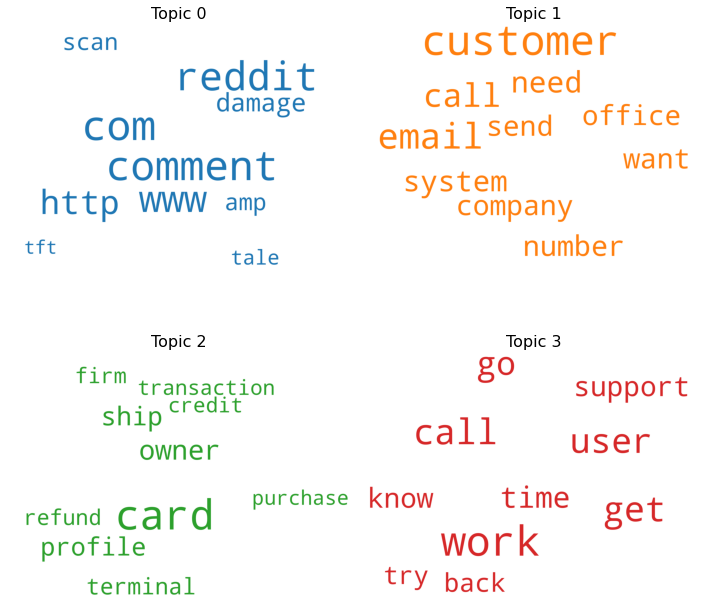

In [86]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

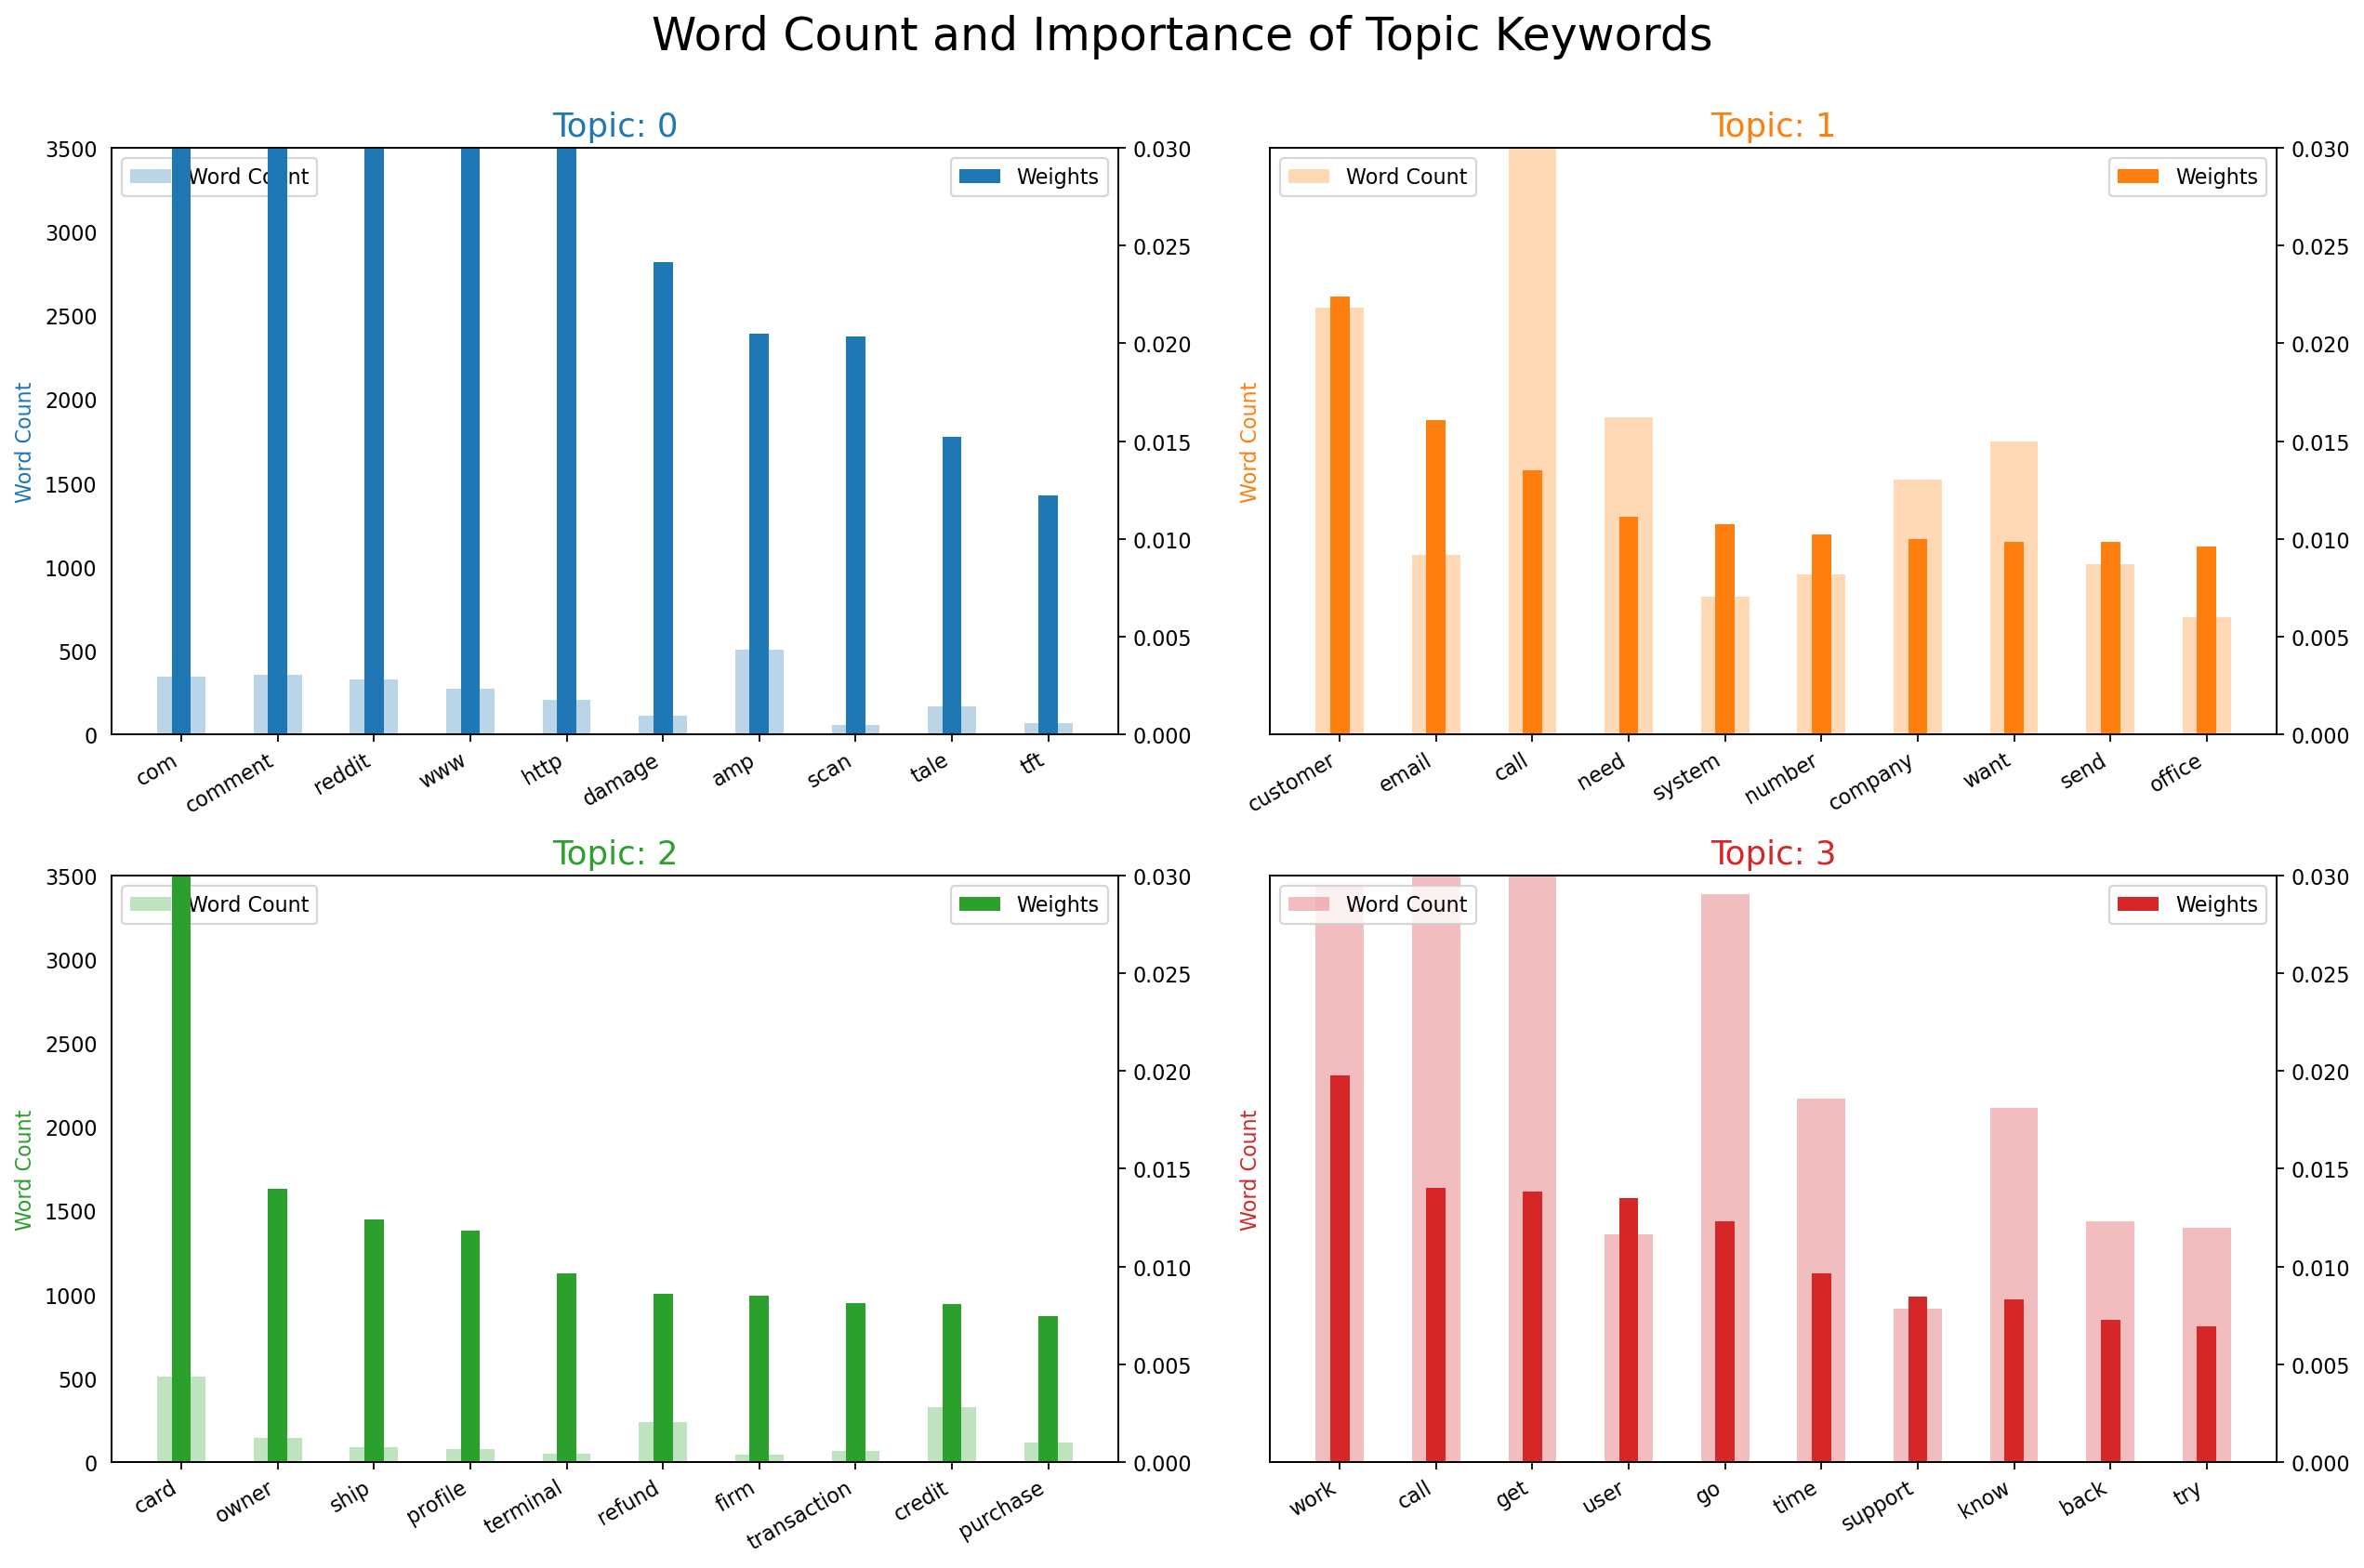

In [110]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [113]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

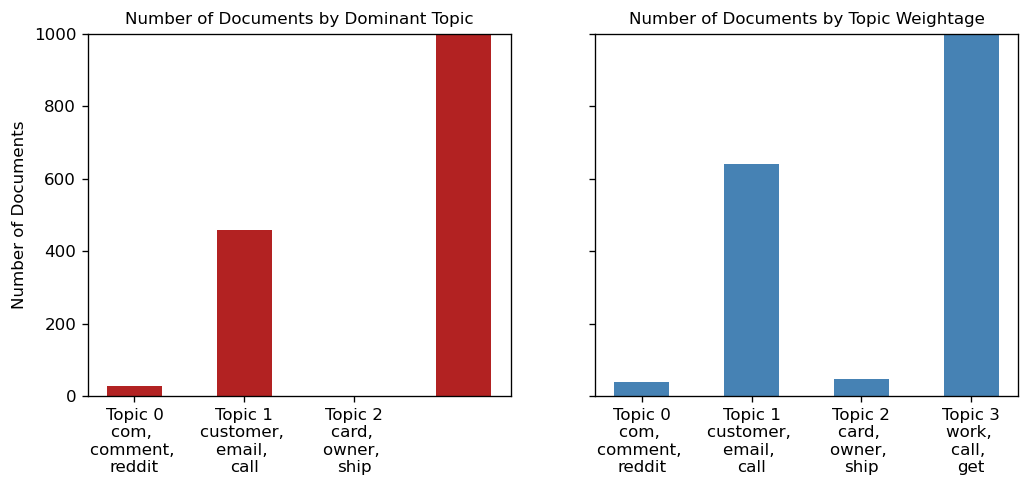

In [89]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [92]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.242403  0.038805       1        1  58.242016
1     -0.231525 -0.031986       2        1  36.718613
2      0.227523 -0.194949       3        1   3.098097
0      0.246405  0.188130       4        1   1.941271, topic_info=           Term         Freq        Total Category  logprob  loglift
127    customer  2458.000000  2458.000000  Default  30.0000  30.0000
836       email  1728.000000  1728.000000  Default  29.0000  29.0000
119         com   411.000000   411.000000  Default  28.0000  28.0000
378     comment   407.000000   407.000000  Default  27.0000  27.0000
67       reddit   380.000000   380.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
531         top    34.432083   220.019623   Topic4  -5.1068   2.0871
11088   blocker    15.501915    27.779364   Topic4  -5.9048   3.3585
271        post    21.009846   267.650360   Topic4  -5.6008   1.3971
143        find    16.245682  1005.902954   Topic4  -5.8580  -0.1840
887       enjoy    14.114879    44.047882   Topic4  -5.9986   2.8038

[222 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
10817      1  0.055305  aarush
10817      2  0.082958  aarush
10817      3  0.082958  aarush
10817      4  0.774277  aarush
673        2  0.997944  access
...      ...       ...     ...
41         2  0.058517    work
264        1  0.453471   would
264        2  0.546253   would
754        2  0.997680   write
3425       4  0.996977     www

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [116]:
df.shape

(1742, 2)

In [117]:
reddit_df.shape

(1743, 13)

In [120]:
df.head()

,Document_Id,Dominant_Topic
0,0,3
1,1,1
2,2,1
3,3,0
4,4,3


In [132]:
sentiment_df = pd.merge(df, reddit_df, left_index=True, right_index=True)

In [133]:
sentiment_df.head()

,Document_Id,Dominant_Topic,title,post,upvotes,gilded,belongs_to_sub2,title_x_post,token,joined_text,highly_upvoted,word_count,char_count,cleaned_text,scores,compound,comp_score,is_positive
0,0,3,Just need to vent...,"I get that tempers are shorter these days, but I am having a hard time lately with people taking...",230,0,0,"Just need to vent... I get that tempers are shorter these days, but I am having a hard time late...","['need', 'vent', 'get', 'tempers', 'shorter', 'days', 'hard', 'time', 'lately', 'people', 'takin...","Just need to vent... I get that tempers are shorter these days, but I am having a hard time late...",1,48,579,need vent get tempers shorter days hard time lately people taking frustrations happen convenient...,"{'neg': 0.194, 'neu': 0.467, 'pos': 0.339, 'compound': 0.8834}",0.8834,pos,1
1,1,1,Reverse call center post,On mobile so I hope I do this right. \n\nI had to call about a bill we keep getting for trash s...,39,0,0,Reverse call center post On mobile so I hope I do this right. \n\nI had to call about a bill we...,"['reverse', 'call', 'center', 'post', 'mobile', 'hope', 'right', 'call', 'bill', 'keep', 'gettin...",Reverse call center post On mobile so I hope I do this right. \n\nI had to call about a bill we...,0,84,1017,reverse call center post mobile hope right call bill keep getting trash service cancelled septem...,"{'neg': 0.112, 'neu': 0.645, 'pos': 0.243, 'compound': 0.9183}",0.9183,pos,1
2,2,1,"""So you're willing to lose a customer for $3 dollars?""",I work for a car rental company as a specialist. Basically when a customer demands a supervisor ...,763,0,0,"""So you're willing to lose a customer for $3 dollars?"" I work for a car rental company as a spec...","['willing', 'lose', 'customer', 'dollars', 'work', 'car', 'rental', 'company', 'specialist', 'ba...","""So you're willing to lose a customer for $3 dollars?"" I work for a car rental company as a spec...",1,585,6757,willing lose customer dollars work car rental company specialist basically customer demands supe...,"{'neg': 0.136, 'neu': 0.657, 'pos': 0.207, 'compound': 0.9939}",0.9939,pos,1
3,3,0,Free Talk Friday - Nov 27,Welcome to Free Talk Friday! We are suspending the usual 'tales only' rule within this thread (o...,0,0,0,Free Talk Friday - Nov 27 Welcome to Free Talk Friday! We are suspending the usual 'tales only' ...,"['free', 'talk', 'friday', 'nov', 'welcome', 'free', 'talk', 'friday', 'suspending', 'usual', 't...",Free Talk Friday - Nov 27 Welcome to Free Talk Friday! We are suspending the usual 'tales only' ...,0,38,368,free talk friday nov welcome free talk friday suspending usual tales rule within thread rules st...,"{'neg': 0.169, 'neu': 0.562, 'pos': 0.269, 'compound': 0.6124}",0.6124,pos,1
4,4,3,Accidentally Exposed a Family Fraud,I work for a small local ISP. One of the things I sometime do is help out the billing person &a...,958,0,0,Accidentally Exposed a Family Fraud I work for a small local ISP. One of the things I sometime ...,"['accidentally', 'exposed', 'family', 'fraud', 'work', 'small', 'local', 'isp', 'one', 'things',...",Accidentally Exposed a Family Fraud I work for a small local ISP. One of the things I sometime ...,1,366,3608,accidentally exposed family fraud work small local isp one things sometime help billing person a...,"{'neg': 0.171, 'neu': 0.74, 'pos': 0.089, 'compound': -0.988}",-0.9880,neg,0


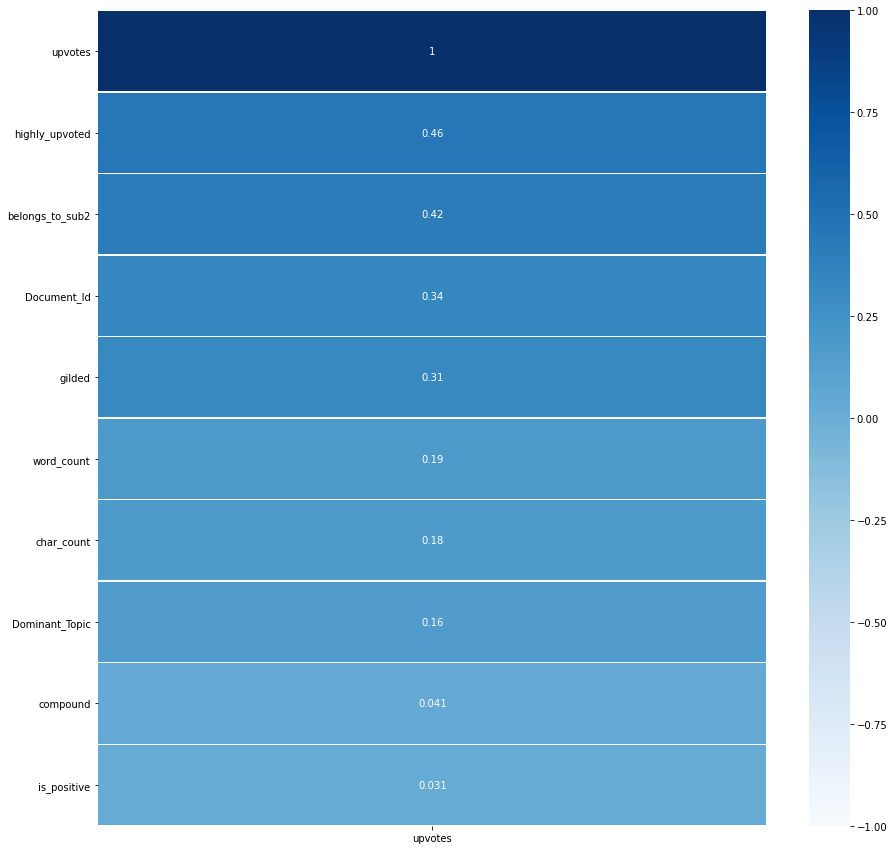

In [140]:
#correlation heatmap with just the upvotes column 
plt.figure(figsize = (15,15))
sns.heatmap(sentiment_df.corr()[['upvotes']].sort_values(by=['upvotes'], ascending = False),
            annot=True, vmin=-1, vmax=1, linewidths=.5, cmap='Blues');

# My hypothesis was to prove if topic or sentiment impact upvotes, however they both have very low correlation and this may not be worth looking into further